# Property Taxes

The UK taxes land and property together via several different taxes, including recurring taxes on residential property (Council Tax and domestic rates) and on non-residential property (business rates), and one-off taxes of property purchases (Stamp Duties). Some of these taxes are devolved and administered by either the Welsh Revenue Authority or Revenue Scotland rather than by HMRC.

## Total Revenue by Tax

### Council Tax

We validate Council Tax revenue against outturn and projections by the Office for Budget Responsibility[^1]

[^1]: https://obr.uk/forecasts-in-depth/tax-by-tax-spend-by-spend/council-tax/

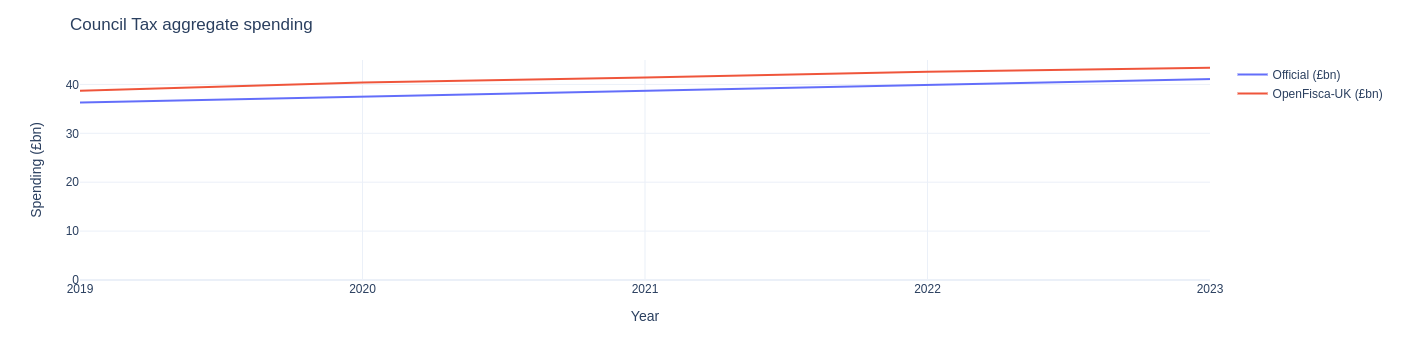

In [6]:
from openfisca_uk import Microsimulation
import pandas as pd
import plotly.express as px

sim = Microsimulation()

df = pd.DataFrame(
    {
        "Year": list(range(2019, 2024)),
        "Official (£bn)": [36.3, 37.5, 38.7, 39.9, 41.1],
        "OpenFisca-UK (£bn)": [
            round(
                (
                    sim.calc("council_tax", year).sum()
                    - sim.calc("council_tax_benefit", year).sum()
                )
                / 1e9,
                1,
            )
            for year in range(2019, 2024)
        ],
    }
).set_index("Year")
df["Rel. Error (%)"] = round(
    (df["OpenFisca-UK (£bn)"] / df["Official (£bn)"] - 1) * 100, 1
)
df["Abs. Error (£bn)"] = df["OpenFisca-UK (£bn)"] - df["Official (£bn)"]
px.line(
    df, x=df.index, y=["Official (£bn)", "OpenFisca-UK (£bn)"]
).update_layout(
    template="plotly_white",
    title="Council Tax aggregate spending",
    xaxis_tickvals=list(range(2019, 2024)),
    xaxis_title="Year",
    yaxis_title="Spending (£bn)",
    legend_title="",
    yaxis_range=(0, 45),
)

In [2]:
df

,Official (£bn),OpenFisca-UK (£bn),Rel. Error (%),Abs. Error (£bn)
Year,,,,
2019,36.3,38.7,6.6,2.4
2020,37.5,40.4,7.7,2.9
2021,38.7,41.4,7.0,2.7
2022,39.9,42.6,6.8,2.7
2023,41.1,43.4,5.6,2.3


### Stamp Duties

The Family Resources Survey does not contain data on property transfers liable for Stamp Duties, so it must be imputed from elsewhere. To do this, we use the Wealth and Assets Survey to build a predictive model of different wealth variables (value of main residence, value of other residential property, value of non-residential property) from demographic and financial variables shared with the Family Resources Survey (see our more detailed documentation on [imputation across surveys](https://policyengine.github.io/openfisca-uk-data/imputation.html)).

Stamp Duties are devolved: in England and Northern Ireland, Stamp Duty Land Tax is levied on the purchase of property, whereas in Scotland and Wales different taxes are applied (the Land and Buildings Transaction Tax and the Land Transaction Tax, respectively). The rules are broadly similar, though thresholds and reliefs differ.

We validate against the OBR's projections of combined property transaction taxes for the UK (including devolved taxes), as these include forecasts.[^2] At the time of writing, the forecasts on the [Property transaction taxes](https://obr.uk/forecasts-in-depth/tax-by-tax-spend-by-spend/property-transaction-taxes/) summary page *latest forecast* have not been updated to factor in the coronavirus-related stamp duty holiday, which is accounted for in more up-to-date forecasts.

OpenFisca-UK differs more from official estimates in property transaction taxes than other tax-benefit instruments due to several factors:
* Property transaction values and frequency are significantly less stable (and more responsive to tax policy changes) than income or other wealth variables
* The pandemic-related stamp duty holidays were introduced mid-year, whereas the model simulates policy at the start of the year
* Property transaction data is imputed from the Wealth and Assets Survey, rather than in the Family Resources Survey

[^2]: https://obr.uk/efo/economic-and-fiscal-outlook-march-2021/ (Table 3.11)

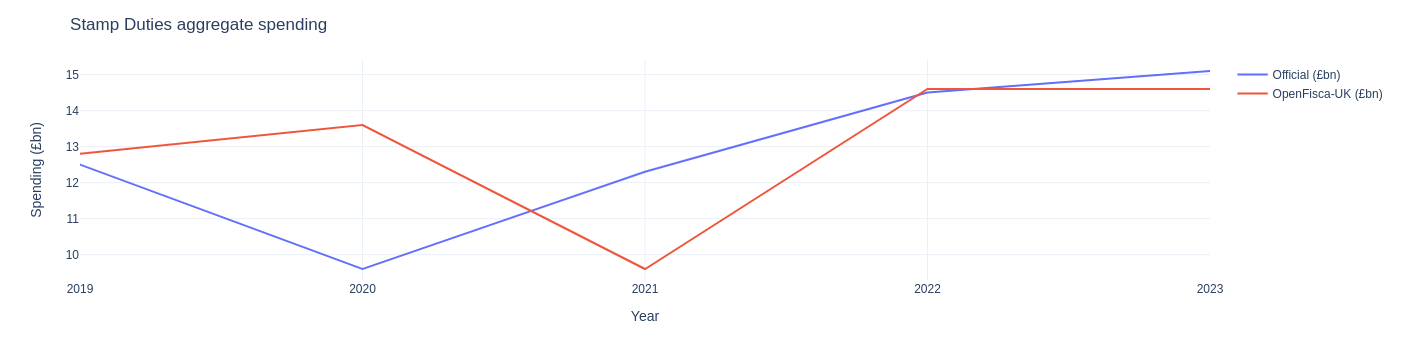

In [3]:
SD_COMPONENTS = [
    "expected_sdlt",
    "expected_ltt",
    "expected_lbtt",
]

df = pd.DataFrame(
    {
        "Year": list(range(2019, 2024)),
        "Official (£bn)": [12.5, 9.6, 12.3, 14.5, 15.1],
        "OpenFisca-UK (£bn)": [
            round(sim.df(SD_COMPONENTS, year).sum().sum() / 1e9, 1)
            for year in range(2019, 2024)
        ],
    }
).set_index("Year")
df["Rel. Error (%)"] = round(
    (df["OpenFisca-UK (£bn)"] / df["Official (£bn)"] - 1) * 100, 1
)
df["Abs. Error (£bn)"] = df["OpenFisca-UK (£bn)"] - df["Official (£bn)"]
px.line(
    df, x=df.index, y=["Official (£bn)", "OpenFisca-UK (£bn)"]
).update_layout(
    template="plotly_white",
    title="Stamp Duties aggregate spending",
    xaxis_tickvals=list(range(2019, 2024)),
    xaxis_title="Year",
    yaxis_title="Spending (£bn)",
    legend_title="",
)

Note: the drop in Stamp Duty revenue here is largely due to pandemic-related policy changes: OpenFisca-UK simulates each year with policy at the start of the year, which is why the drop happens in 2021 rather than 2020 - the policy came into effect mid-2020.

In [4]:
df

,Official (£bn),OpenFisca-UK (£bn),Rel. Error (%),Abs. Error (£bn)
Year,,,,
2019,12.5,12.8,2.4,0.3
2020,9.6,13.6,41.7,4.0
2021,12.3,9.6,-22.0,-2.7
2022,14.5,14.6,0.7,0.1
2023,15.1,14.6,-3.3,-0.5


### Business rates

Business rates are continuous rates levied on non-residential property. Most revenue comes from corporate-owned property for which there is no survey data. OpenFisca-UK assumes that the incidence of business rates falls entirely on shareholders, proportional to the corporate wealth they own. By definition, this implementation matches the total business rates revenue, shown in the table below. Sources for revenue include:
* [National non-domestic rates collected by councils in England](https://www.gov.uk/government/collections/national-non-domestic-rates-collected-by-councils#2021-to-2022)
* [Non-domestic rates estimates by authority (£ thousand) | StatsWales](https://statswales.gov.wales/Catalogue/Local-Government/Finance/Non-Domestic-Rates/Estimates/nondomesticratesestimates-by-authority)
* [Non-domestic rates income statistics (Scotland)](https://www.gov.scot/publications/non-domestic-rates-income-statistics/)
* [2019 Review of Business Rates (Northern Ireland)](https://minutes.belfastcity.gov.uk/documents/s81213/Terms%20of%20Reference.pdf)

In [5]:
pd.DataFrame(
    {
        year: [round(sim.calc("business_rates", year).sum() / 1e9, 2)]
        for year in range(2019, 2022)
    },
    index=["Business rates revenue (£bn)"],
)

,2019,2020,2021
Business rates revenue (£bn),29.27,20.7,31.73
